<a href="https://colab.research.google.com/github/meghakalia/Controllable_Image_Generation/blob/main/T2IAdapter_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌗 Image-to-Image Translation with Stable Diffusion and T2I-Adapter (Depth)
This notebook demonstrates how to transform a daytime scene into a nighttime version using T2I-Adapter with Stable Diffusion XL. We use the depth-based adapter to preserve the structural layout of the original image while guiding the model to generate a photorealistic night scene.

## 🔧 Key Features:

*   Loads a **pretrained T2I-Adapter** (Depth) model from TencentARC
*   **Uses Stable Diffusion XL** for high-quality image generation
* Extracts a depth map from an input day scene image using MiDaS
* **Conditions the diffusion model** with both the depth map and a text prompt (e.g., "a street at night")
* Outputs a high-resolution night version of the original image





# **NOTE**

1. Highly dependent depth quality.
2. Check the depth resolution of the adapter on which it is trained



In [ ]:

# ✅ STEP 1: Install dependencies
!pip install -q diffusers transformers accelerate controlnet-aux opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00


In [ ]:
# ✅ STEP 2: Import packages
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
from controlnet_aux import MidasDetector
from transformers import AutoProcessor

from torchvision import transforms
import requests
from io import BytesIO
from IPython.display import display
from IPython.display import display


from google.colab import files
from PIL import Image


/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [ ]:
# Let the user upload an image
# # ✅ STEP 3: Load an image (You can upload your own in the next step)
uploaded = files.upload()

# Load and resize the image
filename = next(iter(uploaded))
day_img = Image.open(filename).convert("RGB").resize((512, 512))


Saving 2.jpg to 2.jpg


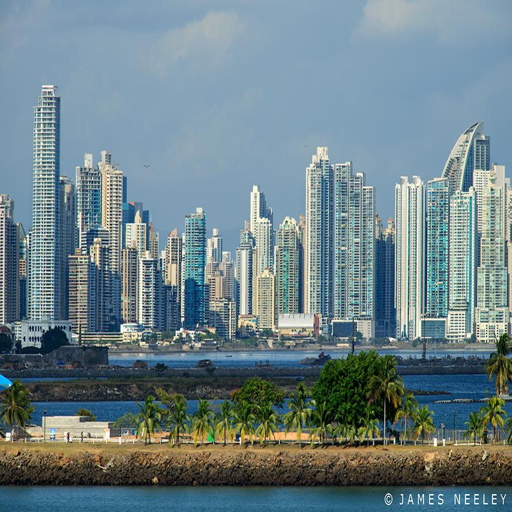

In [ ]:
display(day_img)

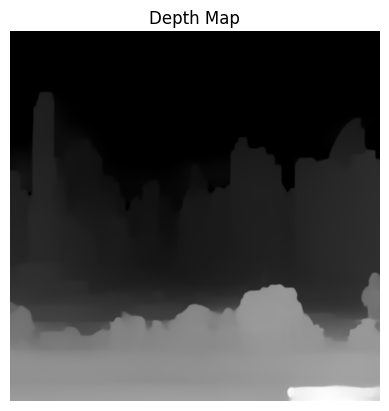

In [ ]:
# ✅ STEP 4: Generate depth map from day image
midas = MidasDetector.from_pretrained("lllyasviel/Annotators")


# midas = MidasDetector.from_pretrained(
#   "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large"
# ).to("cuda")


depth_map = midas(
  day_img, detect_resolution=512, image_resolution=1024
)

# Optional: show depth map
plt.imshow(depth_map, cmap='inferno')
plt.title("Depth Map")
plt.axis("off")
plt.show()



In [ ]:
from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL

In [ ]:
# ✅ STEP 5: Load T2I-Adapter (depth) + Stable Diffusion XL
# load adapter

adapter = T2IAdapter.from_pretrained(
  "TencentARC/t2i-adapter-depth-midas-sdxl-1.0", torch_dtype=torch.float16, varient="fp16"
).to("cuda")

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
euler_a = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16",
).to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Manually delete models/pipes
# del pipe
# del adapter
# del depth_map
# del day_img
# del output

# Run garbage collector
# import gc
# gc.collect()

# # Then clear CUDA cache again
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

In [ ]:
# # ✅ STEP 6: Define prompt to transform day → night
prompt = "Photo of a city sjyline at night, highly detailed"
negative_prompt = negative_prompt = "watermark, trademark, anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

  0%|          | 0/30 [00:00<?, ?it/s]

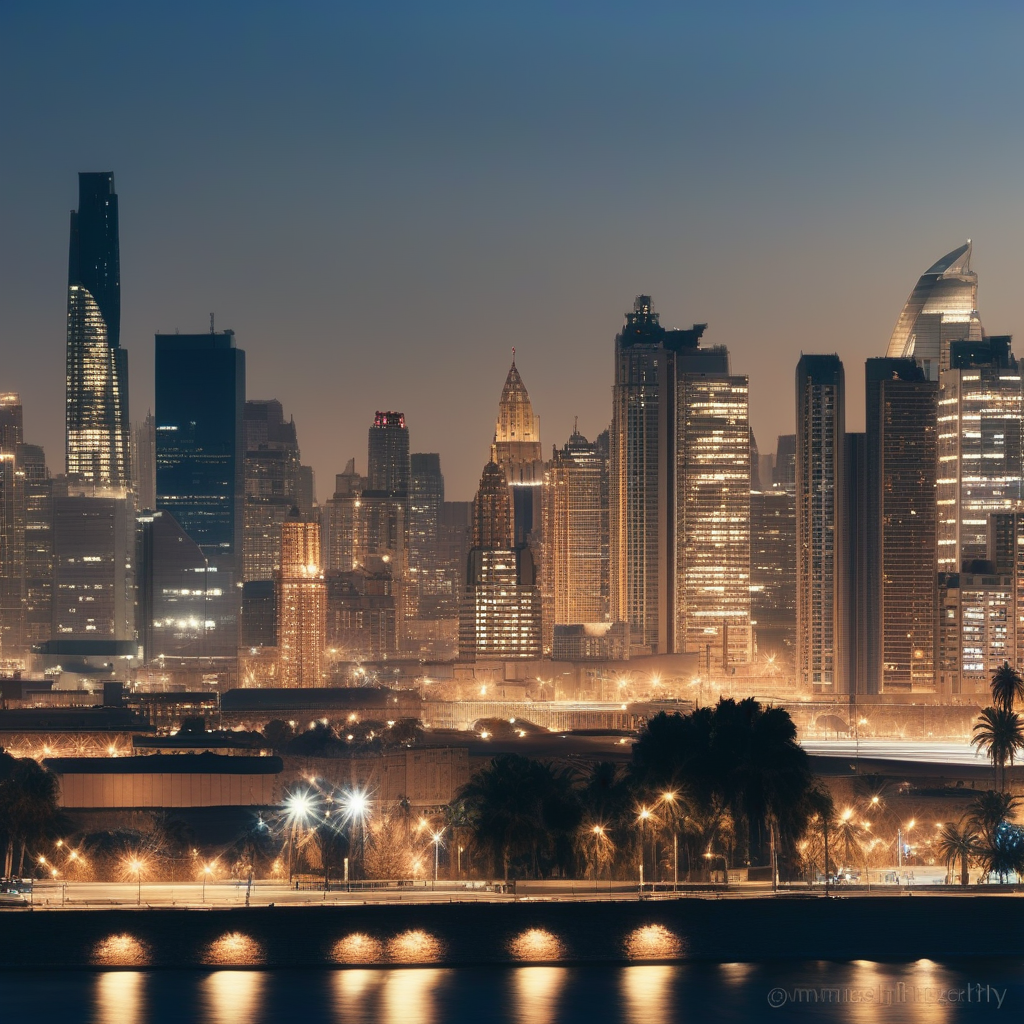

In [ ]:
# ✅ STEP 7: Run generation

output = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=depth_map,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5,
).images[0]

display(output)

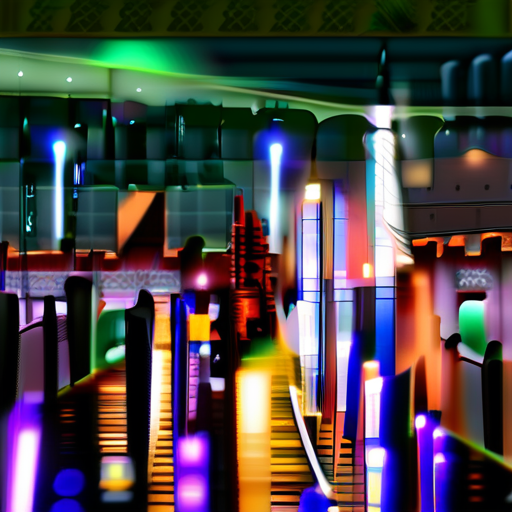

In [ ]:
# Failed with low resolution depth